In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import anndata as ad
import snapatac2 as snap
import matplotlib.pyplot as plt
from umap import UMAP
import seaborn as sns
import pyranges as pr
import os
import warnings
import requests
from tqdm import tqdm
plt.rcdefaults()

from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform
from scipy.stats import mannwhitneyu, false_discovery_control

import sys
sys.path.append('/scratch/eli')
from perturbseq import *
from sparsepca import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

In [5]:
pop = CellPopulation.from_hdf("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/gex_norm_regressed.hdf5")
pop.genes['gene_name'] = pop.genes.index
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    meanpop = pop.average("guide_identity")

Loading matrix...
Loading metadata...
Done in 1.7941246032714844s.
Generating summary statistics...
Done.
Computing average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


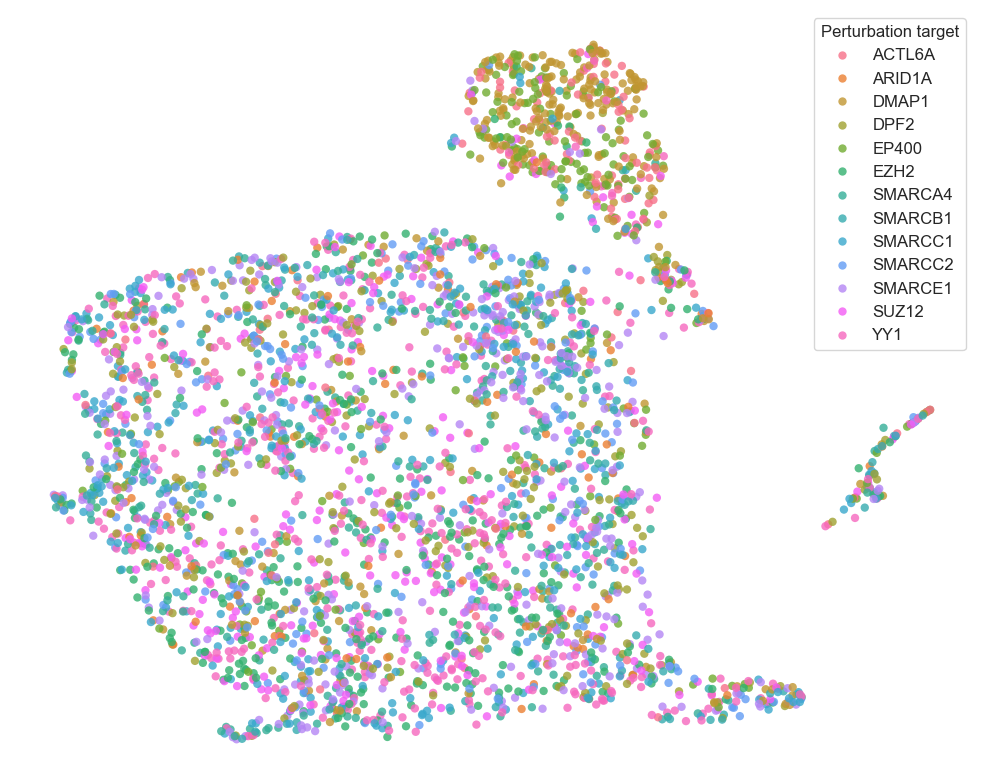

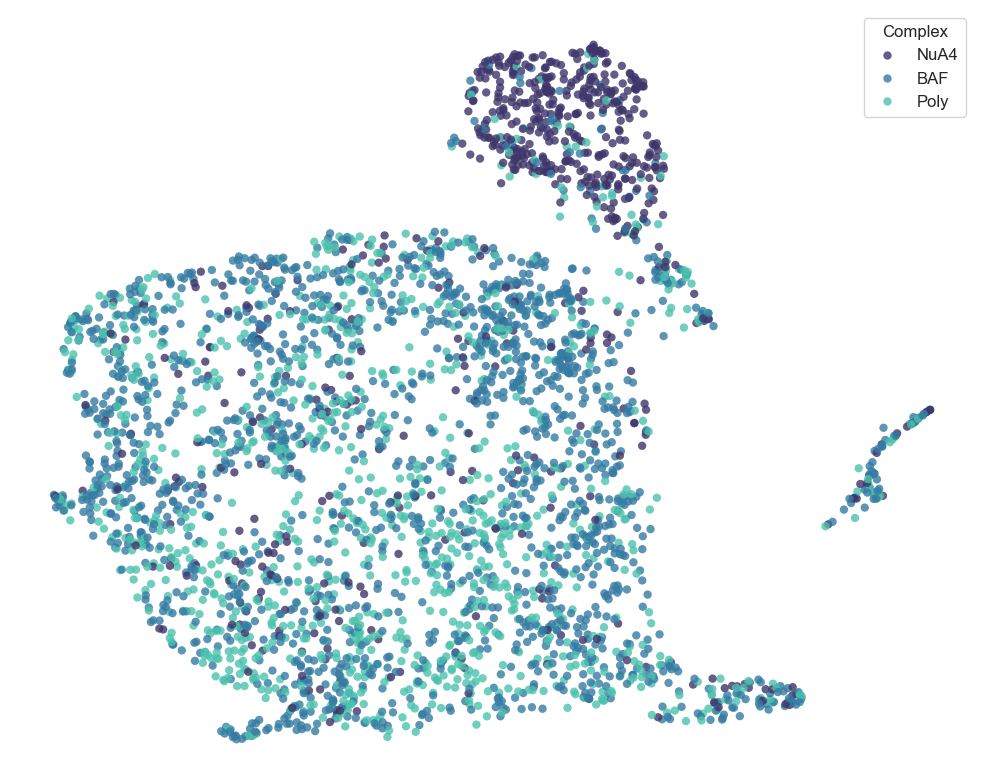

In [25]:
pca = PCAReducer(n_components=10)
pca_rep = pop.fit_transform(pca)
umap = UMAP(n_neighbors=8, min_dist = 0.25, metric = 'correlation', random_state=8)
gex_umap = pd.DataFrame(umap.fit_transform(pca_rep), index = pop.cells.index).join(pop.cells.guide_identity).query("guide_identity != 'NTC'")
gex_umap['complex'] = gex_umap['guide_identity'].map(lambda g: 'NuA4' if g in ['ACTL6A', 'DMAP1', 'EP400'] else 'Poly' if g in ['EZH2', 'SUZ12', 'YY1'] else 'BAF')
gex_umap['Complex'] = pd.Categorical(gex_umap.complex, categories=['NuA4', 'BAF', 'Poly'], ordered = True)
gex_umap['Perturbation target'] = pd.Categorical(gex_umap.guide_identity, categories=['ACTL6A', 'ARID1A', 'DMAP1', 'DPF2', 'EP400', 'EZH2', 'SMARCA4', 'SMARCB1', 'SMARCC1', 'SMARCC2', 'SMARCE1', 'SUZ12', 'YY1'], ordered = True)
# gex_umap['Perturbation target'] = pd.Categorical(gex_umap.guide_identity, categories=['DMAP1', 'ACTL6A', 'EP400', 'YY1', 'EZH2', 'SUZ12', 'SMARCA4', 'ARID1A', 'SMARCC2', 'SMARCB1', 'SMARCE1', 'DPF2', 'SMARCC1'], ordered = True)

with sns.axes_style("white"):
    
    plt.figure(figsize = (10,8))
    ax = sns.scatterplot(data = gex_umap, x = 0, y = 1, edgecolor = 'none', alpha = 0.8, hue = 'Perturbation target')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    # plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs/SxxA_gex_umap_id.pdf")
    plt.show()

    plt.figure(figsize = (10,8))
    ax = sns.scatterplot(data = gex_umap, x = 0, y = 1, edgecolor = 'none', alpha = 0.8, hue = 'Complex', palette = 'mako')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    # plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs/SxxA_gex_umap_complex.pdf")
    plt.show()

In [10]:
atac = snap.read("../figs/intermediate_files/Lane1_040_preprocessed_atac.h5ad", backed = None)
atac = atac[atac.obs.index.isin(pop.cells.index)]
atac = atac[:,atac.var.selected].copy()
atac.obs = atac.obs.join(pop.cells.guide_identity)

snap.tl.spectral(atac, n_comps = 11)
df = pd.DataFrame(atac.obsm['X_spectral'], index = atac.obs.index).join(pop.cells.guide_identity)

df_first_comp_removed = df.iloc[:,1:]

In [11]:
coembed = pd.concat([pca_rep, df_first_comp_removed], axis = 1).drop("guide_identity", axis = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
coembed.columns = coembed.columns.astype(str)
coembed_scaled = pd.DataFrame(scaler.fit_transform(coembed), index = coembed.index, columns = coembed.columns)
coembed_scaled

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,1,2,3,4,5,6,7,8,9
AAACAGCCAGCCAGTT-1,1.232407,1.971115,-2.286531,0.546401,0.457209,-0.583560,-0.663247,0.204536,-1.951320,-0.256116,-1.457958,0.739445,0.179756,-0.051181,0.183807,-1.731034,-0.530316,-3.793483,-2.432598
AAACAGCCAGGCTAAG-1,-0.368907,0.740967,1.202078,-0.211904,-0.758881,-0.258593,-0.073201,-0.237786,2.234460,-0.624113,0.544618,1.758596,-0.549378,0.659298,0.629957,1.577630,-0.855761,-1.449977,1.198992
AAACAGCCAGTTGCGT-1,0.082576,-0.290470,-0.729516,-0.335296,0.195483,-0.160173,-0.094744,0.025201,-0.588295,-0.142016,-0.186271,0.346611,0.983096,-1.450706,0.023738,-0.193416,-0.935427,-0.403852,0.459726
AAACATGCAAGGAATC-1,-0.181361,1.021310,1.007987,0.376506,-0.375198,-0.249680,-0.015801,-0.172292,2.228787,-0.535189,-0.324930,1.590552,0.044850,1.195520,0.873462,1.121282,0.151526,0.677781,-0.671254
AAACATGCATCCATCT-1,0.099312,1.491141,0.205890,0.195151,-0.619925,0.025706,0.122148,-0.059263,-0.573066,-0.890571,1.013023,-0.680830,-1.662673,0.897654,0.040036,-0.188265,-0.939545,1.633590,-0.281734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCGTGCCTT-1,0.327006,-0.878430,-1.283495,0.150123,0.267468,0.118386,0.240936,-0.545953,1.253139,-0.377128,0.255276,-1.087444,-0.084144,-0.095957,1.184101,-1.483238,0.232256,0.032750,-0.123809
TTTGTGTTCTTGTTCG-1,-0.724072,0.238072,1.521197,1.371780,0.072399,-0.234965,0.561398,-0.229511,-0.294117,0.499562,0.165325,1.230269,0.114291,0.648867,0.374911,1.709507,-0.624194,-0.130137,-0.910125
TTTGTTGGTCTCACTG-1,-0.149493,0.629131,0.277966,0.495887,-0.655346,-0.068740,-0.324601,0.060889,-0.657468,-0.945877,0.822797,-1.479654,-0.788672,0.682797,-0.950467,0.238098,-1.114866,0.111302,0.637494
TTTGTTGGTGAGCGAA-1,1.144633,0.426793,-1.986340,2.442904,-0.358215,-1.495884,-0.278931,-0.314963,1.581094,1.453396,1.026810,1.608840,-0.508982,-0.518199,1.462115,-1.578768,0.143181,-0.173681,0.116363


/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-09-20 11:48:09 - INFO - maxp pruned
2024-09-20 11:48:09 - INFO - LTSH dropped
2024-09-20 11:48:09 - INFO - cmap pruned
2024-09-20 11:48:09 - INFO - kern pruned
2024-09-20 11:48:09 - INFO - post pruned
2024-09-20 11:48:09 - INFO - PCLT dropped
2024-09-20 11:48:09 - INFO - GSUB pruned
2024-09-20 11:48:09 - INFO - JSTF dropped
2024-09-20 11:48:09 - INFO - DSIG dropped
2024-09-20 11:48:09 - INFO - name pruned
2024-09-20 11:48:09 - INFO - glyf pruned
2024-09-20 11:48:09 - INFO - Added gid0 to subset
2024-09-20 11:48:09 - INFO - Added first four glyphs to subset
2024-09-20 11:48:09 - INFO - Closing glyph list over 'GSUB': 36 glyphs before
2024-09-20 11:48:09 - INFO - Glyph names: ['.notdef', '.null', 'A

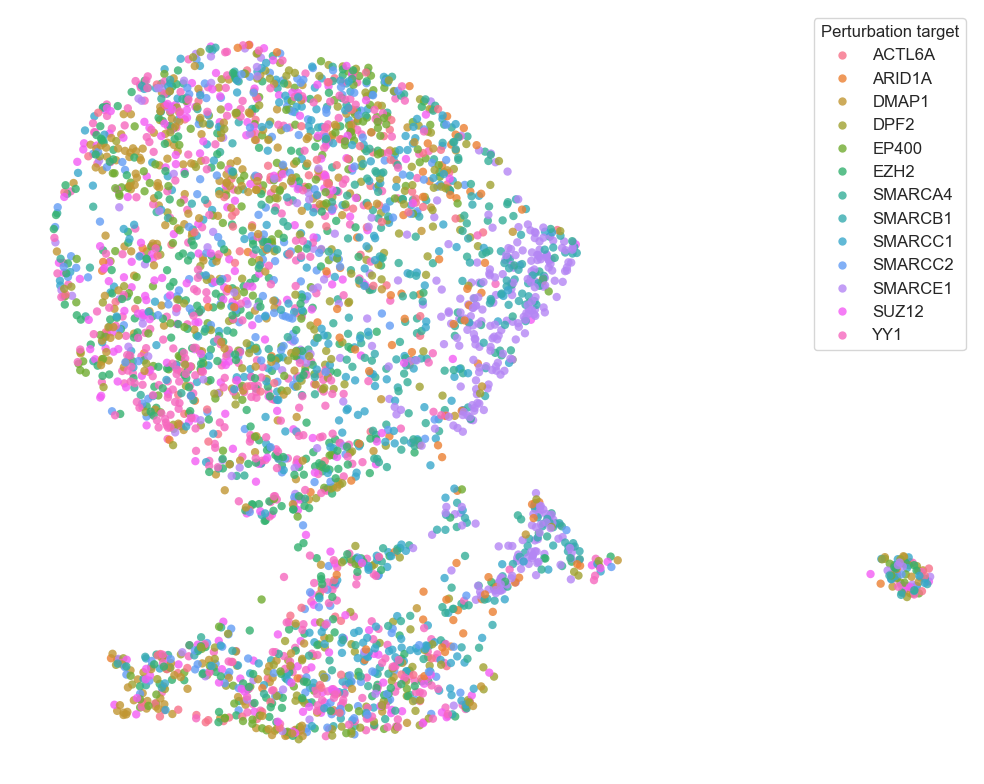

2024-09-20 11:48:09 - INFO - maxp pruned
2024-09-20 11:48:09 - INFO - LTSH dropped
2024-09-20 11:48:09 - INFO - cmap pruned
2024-09-20 11:48:09 - INFO - kern pruned
2024-09-20 11:48:09 - INFO - post pruned
2024-09-20 11:48:09 - INFO - PCLT dropped
2024-09-20 11:48:09 - INFO - GSUB pruned
2024-09-20 11:48:09 - INFO - JSTF dropped
2024-09-20 11:48:09 - INFO - DSIG dropped
2024-09-20 11:48:09 - INFO - name pruned
2024-09-20 11:48:09 - INFO - glyf pruned
2024-09-20 11:48:09 - INFO - Added gid0 to subset
2024-09-20 11:48:09 - INFO - Added first four glyphs to subset
2024-09-20 11:48:09 - INFO - Closing glyph list over 'GSUB': 19 glyphs before
2024-09-20 11:48:09 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'F', 'N', 'P', 'e', 'four', 'l', 'm', 'nonmarkingreturn', 'o', 'p', 'space', 'u', 'x', 'y']
2024-09-20 11:48:09 - INFO - Glyph IDs:   [0, 1, 2, 3, 23, 36, 37, 38, 41, 49, 51, 72, 79, 80, 82, 83, 88, 91, 92]
2024-09-20 11:48:09 - INFO - Closed glyph list over 'GSUB': 19 glyphs

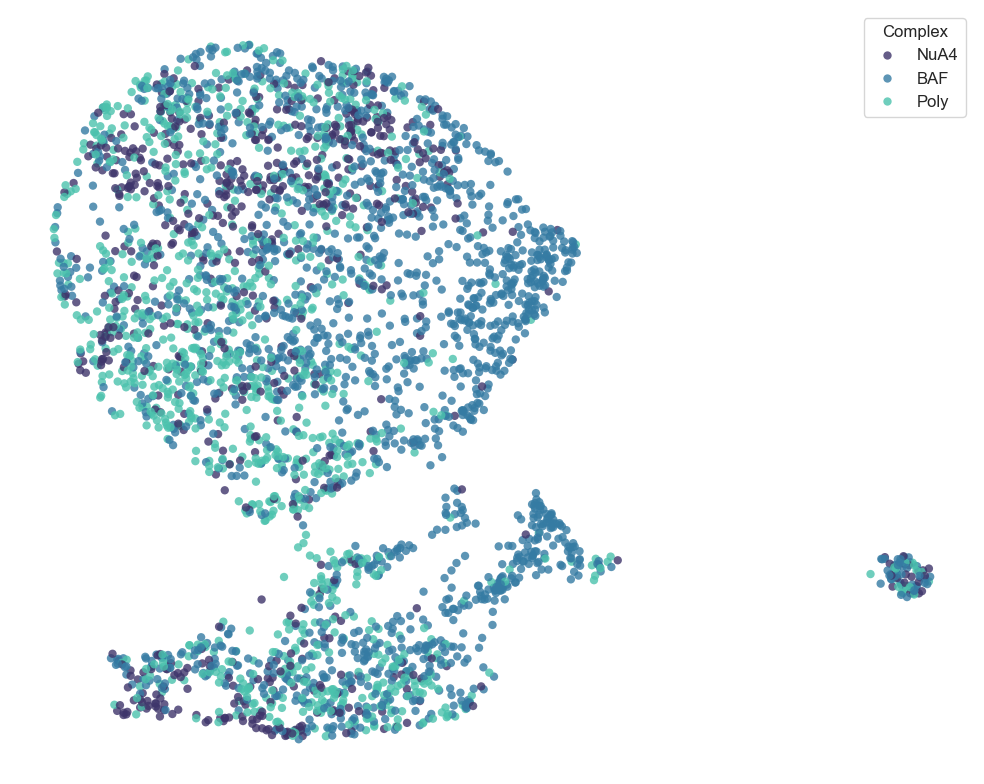

In [18]:
umap_transformer = UMAP(n_neighbors=8, min_dist = 0.25, metric = 'cosine', random_state=8)
umap_rep = pd.DataFrame(umap_transformer.fit_transform(df_first_comp_removed.query("guide_identity != 'NTC'").drop("guide_identity", axis = 1)), index = df_first_comp_removed.query("guide_identity != 'NTC'").index)
atac_umap = umap_rep.join(pop.cells.guide_identity)
atac_umap['complex'] = atac_umap['guide_identity'].map(lambda g: 'NuA4' if g in ['ACTL6A', 'DMAP1', 'EP400'] else 'Poly' if g in ['EZH2', 'SUZ12', 'YY1'] else 'BAF')
atac_umap['Complex'] = pd.Categorical(atac_umap.complex, categories=['NuA4', 'BAF', 'Poly'], ordered = True)
atac_umap['Perturbation target'] = pd.Categorical(atac_umap.guide_identity, categories=['ACTL6A', 'ARID1A', 'DMAP1', 'DPF2', 'EP400', 'EZH2', 'SMARCA4', 'SMARCB1', 'SMARCC1', 'SMARCC2', 'SMARCE1', 'SUZ12', 'YY1'], ordered = True)
with sns.axes_style("white"):
    
    plt.figure(figsize = (10,8))
    ax = sns.scatterplot(data = atac_umap, x = 0, y = 1, edgecolor = 'none', alpha = 0.8, hue = 'Perturbation target')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs/SxxB_atac_umap_id.pdf")
    plt.show()

    plt.figure(figsize = (10,8))
    ax = sns.scatterplot(data = atac_umap, x = 0, y = 1, edgecolor = 'none', alpha = 0.8, hue = 'Complex', palette = sns.color_palette("mako", 3).as_hex())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs/SxxB_atac_umap_complex.pdf")
    plt.show()

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2024-09-20 12:22:37 - INFO - maxp pruned
2024-09-20 12:22:37 - INFO - LTSH dropped
2024-09-20 12:22:37 - INFO - cmap pruned
2024-09-20 12:22:37 - INFO - kern pruned
2024-09-20 12:22:37 - INFO - post pruned
2024-09-20 12:22:37 - INFO - PCLT dropped
2024-09-20 12:22:37 - INFO - GSUB pruned
2024-09-20 12:22:37 - INFO - JSTF dropped
2024-09-20 12:22:37 - INFO - DSIG dropped
2024-09-20 12:22:37 - INFO - name pruned
2024-09-20 12:22:37 - INFO - glyf pruned
2024-09-20 12:22:37 - INFO - Added gid0 to subset
2024-09-20 12:22:37 - INFO - Added first four glyphs to subset
2024-09-20 12:22:37 - INFO - Closing glyph list over 'GSUB': 36 glyphs before
2024-09-20 12:22:37 - INFO - Glyph names: ['.notdef', '.null', 'A

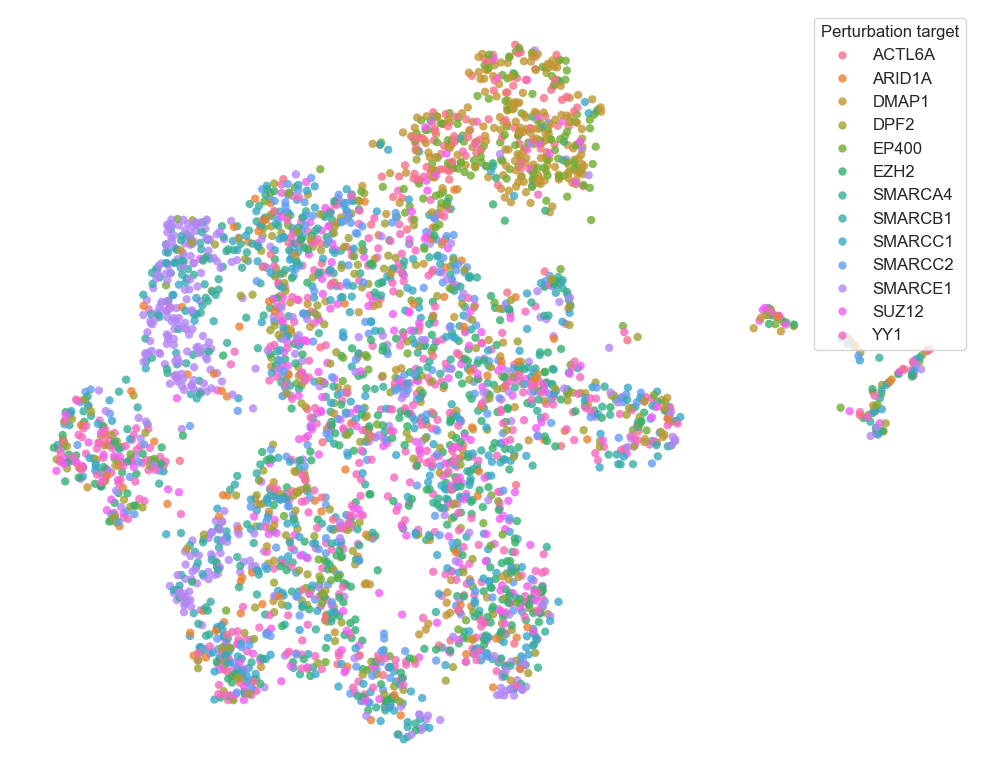

2024-09-20 12:22:38 - INFO - maxp pruned
2024-09-20 12:22:38 - INFO - LTSH dropped
2024-09-20 12:22:38 - INFO - cmap pruned
2024-09-20 12:22:38 - INFO - kern pruned
2024-09-20 12:22:38 - INFO - post pruned
2024-09-20 12:22:38 - INFO - PCLT dropped
2024-09-20 12:22:38 - INFO - GSUB pruned
2024-09-20 12:22:38 - INFO - JSTF dropped
2024-09-20 12:22:38 - INFO - DSIG dropped
2024-09-20 12:22:38 - INFO - name pruned
2024-09-20 12:22:38 - INFO - glyf pruned
2024-09-20 12:22:38 - INFO - Added gid0 to subset
2024-09-20 12:22:38 - INFO - Added first four glyphs to subset
2024-09-20 12:22:38 - INFO - Closing glyph list over 'GSUB': 19 glyphs before
2024-09-20 12:22:38 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'F', 'N', 'P', 'e', 'four', 'l', 'm', 'nonmarkingreturn', 'o', 'p', 'space', 'u', 'x', 'y']
2024-09-20 12:22:38 - INFO - Glyph IDs:   [0, 1, 2, 3, 23, 36, 37, 38, 41, 49, 51, 72, 79, 80, 82, 83, 88, 91, 92]
2024-09-20 12:22:38 - INFO - Closed glyph list over 'GSUB': 19 glyphs

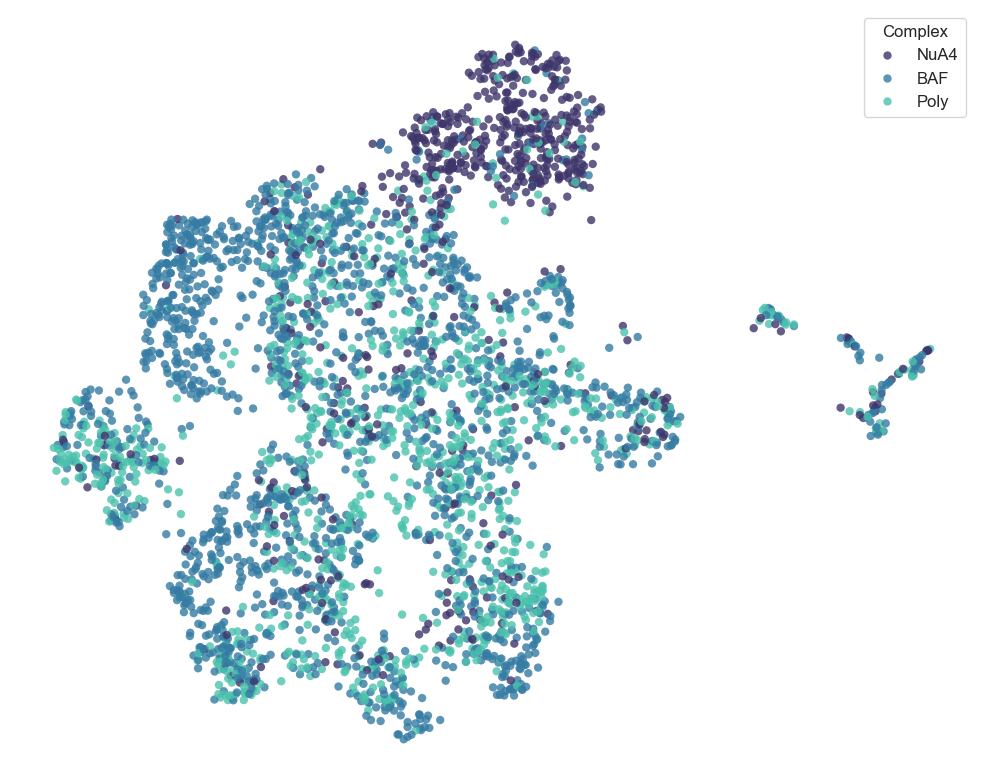

In [26]:
coembed_labeled = coembed_scaled.join(df_first_comp_removed.guide_identity)

umap_transformer = UMAP(n_neighbors=8, min_dist = 0.25, metric = 'correlation', densmap=False, random_state=8)
umap_rep = pd.DataFrame(umap_transformer.fit_transform(coembed_labeled.query("guide_identity != 'NTC'").drop("guide_identity", axis = 1)), index = df_first_comp_removed.query("guide_identity != 'NTC'").index)
umap = umap_rep.join(pop.cells.guide_identity)
umap['complex'] = umap['guide_identity'].map(lambda g: 'NuA4' if g in ['ACTL6A', 'DMAP1', 'EP400'] else 'Poly' if g in ['EZH2', 'SUZ12', 'YY1'] else 'BAF')
umap['Complex'] = pd.Categorical(umap.complex, categories=['NuA4', 'BAF', 'Poly'], ordered = True)
umap['Perturbation target'] = pd.Categorical(umap.guide_identity, categories=['ACTL6A', 'ARID1A', 'DMAP1', 'DPF2', 'EP400', 'EZH2', 'SMARCA4', 'SMARCB1', 'SMARCC1', 'SMARCC2', 'SMARCE1', 'SUZ12', 'YY1'], ordered = True)

with sns.axes_style("white"):
    
    plt.figure(figsize = (10,8))
    ax = sns.scatterplot(data = umap, x = 0, y = 1, edgecolor = 'none', alpha = 0.8, hue = 'Perturbation target')
    sns.move_legend(ax, "upper right")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs/SxxC_coembed_umap_id.pdf")
    plt.show()

    plt.figure(figsize = (10,8))
    ax = sns.scatterplot(data = umap, x = 0, y = 1, edgecolor = 'none', alpha = 0.8, hue = 'Complex', palette = sns.color_palette("mako", 3).as_hex())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs/SxxC_coembed_umap_complex.pdf")
    plt.show()